In [91]:
import os
import tqdm

from collections import defaultdict

import numpy as np

import ase
from ase import data
from ase.visualize import view
from ase import io
from ase.geometry import analysis, distance, get_angles

import matplotlib.pyplot as plt
import seaborn as sns

elements = ["H", "C", "N", "O", "F", "Cl", "Br"]

In [61]:
def load_xyz(fname, valid_elements=None):
    """
    Load a xyz file into an ASE atoms object
    """

    xyzs = []
    Zs = []

    with open(fname) as f:
        line = f.readline().strip()
        N = int(line)

        _ = f.readline().strip()

        for i, line in enumerate(f):
            if i >= N:
                break
            wds = line.split()
            Z = int(wds[0])
            xyzs.append((float(wds[1]), float(wds[2]), float(wds[3])))
            Zs.append(Z)

    xyzs = np.array(xyzs, dtype=np.float64)
    Zs = np.array(Zs, dtype=np.int32)

    if valid_elements is not None:
        if any(Z not in valid_elements for Z in Zs):
            return None

    mol = ase.Atoms(numbers=Zs, positions=xyzs)

    return mol

In [84]:
molecule_dir = '/l/mol_database/'
molecules = [
    load_xyz(os.path.join(molecule_dir, fname), valid_elements=[1, 6, 7, 8, 9, 17, 35])
    for i, fname in enumerate(os.listdir(molecule_dir))
    if i < 10000
]
# Remove None values
molecules = [mol for mol in molecules if mol is not None]
print(f"Loaded {len(molecules)} molecules")

Loaded 8133 molecules


In [88]:
def compute_bond_lengths(molecules):
    bond_lengths = defaultdict(list)
    
    for atoms in molecules:
        positions = atoms.get_positions()
        symbols = atoms.get_chemical_symbols()
        
        # Loop through all unique pairs of atoms
        for i in range(len(atoms)):
            for j in range(i + 1, len(atoms)):
                pair = tuple(sorted([symbols[i], symbols[j]]))
                pos1, pos2 = positions[i], positions[j]
                bond_length = np.linalg.norm(pos1 - pos2)
                
                if bond_length < 1.5 * (data.covalent_radii[atoms[i].number] + data.covalent_radii[atoms[j].number]):
                    bond_lengths[pair].append(bond_length)
    
    return bond_lengths

def plot_bond_length_distributions(bond_lengths):
    ncols = 6
    nrows = int(np.ceil(len(bond_lengths) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))
    axes = axes.flatten()
    for i, (atom_pair, lengths) in enumerate(bond_lengths.items()):
        sns.histplot(lengths, kde=True, bins=50, color='b', alpha=0.6, ax=axes[i], stat='density')
        axes[i].set_title(f"{atom_pair[0]}-{atom_pair[1]}")
        axes[i].set_xlabel("Bond length (Å)")
        axes[i].set_ylabel("Frequency")
        
    plt.tight_layout()


In [89]:
bond_length_dict = compute_bond_lengths(molecules)

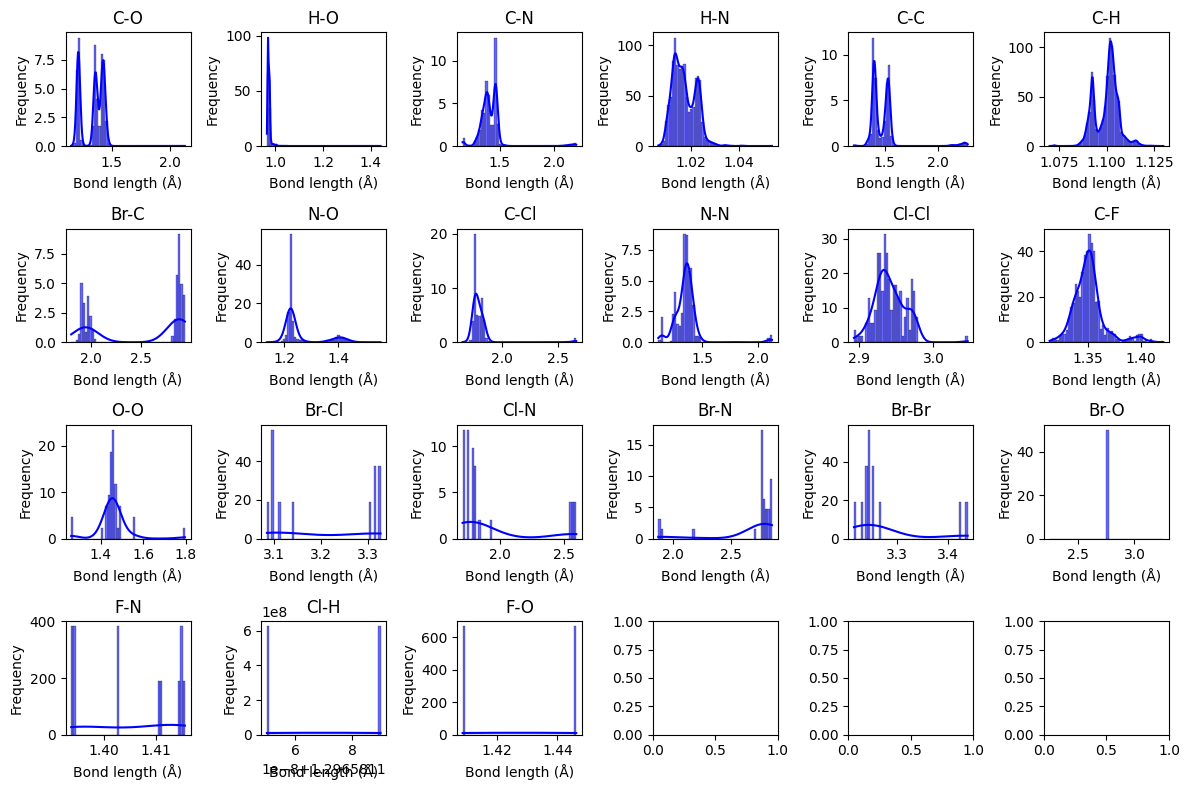

In [90]:
plot_bond_length_distributions(bond_length_dict)

Angles

In [98]:
def compute_bond_angles(molecules):
    """
    Compute bond angles for atom triplets that are bonded.

    Args:
        molecules (list): List of ase.Atoms objects.
        cutoff (float): Maximum distance to consider atoms as bonded.

    Returns:
        dict: Dictionary with atom type triplets as keys and list of angles.
    """
    bond_angles = defaultdict(list)

    for atoms in molecules:
        positions = atoms.get_positions()
        symbols = atoms.get_chemical_symbols()
        num_atoms = len(atoms)

        # Find bonded atom pairs within cutoff
        distances = atoms.get_all_distances(mic=True)
        bonded_pairs = [
            (i, j) for i in range(num_atoms) 
            for j in range(i + 1, num_atoms) if distances[i, j] < 1.5 * (data.covalent_radii[atoms[i].number] + data.covalent_radii[atoms[j].number])
        ]

        # Find triplets where atoms are bonded
        for i, j in bonded_pairs:
            for k in range(num_atoms):
                if k != i and k != j:
                    # Check if k is bonded to both i and j
                    if (i, k) in bonded_pairs or (k, i) in bonded_pairs:
                        if (j, k) in bonded_pairs or (k, j) in bonded_pairs:
                            triplet = tuple(sorted([symbols[i], symbols[j], symbols[k]]))
                            v0 = positions[i] - positions[j]
                            v1 = positions[k] - positions[j]
                            angle = np.arccos(np.dot(v0, v1) / (np.linalg.norm(v0) * np.linalg.norm(v1)))
                            bond_angles[triplet].append(np.degrees(angle))  # Convert radians to degrees

    return bond_angles

def plot_bond_angle_distributions(bond_angles):
    """
    Plot bond angle distributions for different atom triplets.

    Args:
        bond_angles (dict): Dictionary with triplets as keys and angles as values.
    """
    for atom_triplet, angles in bond_angles.items():
        plt.figure(figsize=(8, 5))
        sns.histplot(angles, kde=True, bins=50, color='g', alpha=0.6)
        plt.title(f"Bond Angle Distribution: {'-'.join(atom_triplet)}")
        plt.xlabel("Bond Angle (degrees)")
        plt.ylabel("Frequency")
        plt.xlim(0, 180)  # Bond angles range from 0 to 180 degrees
        plt.grid(True)
        plt.show()

In [99]:
bond_angle_dict = compute_bond_angles(molecules)

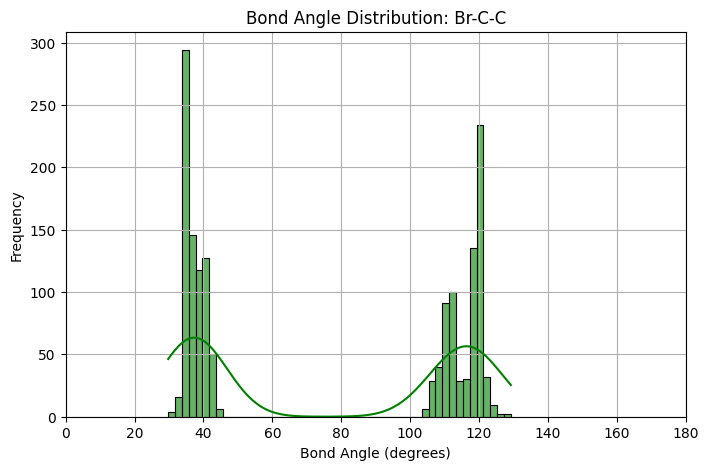

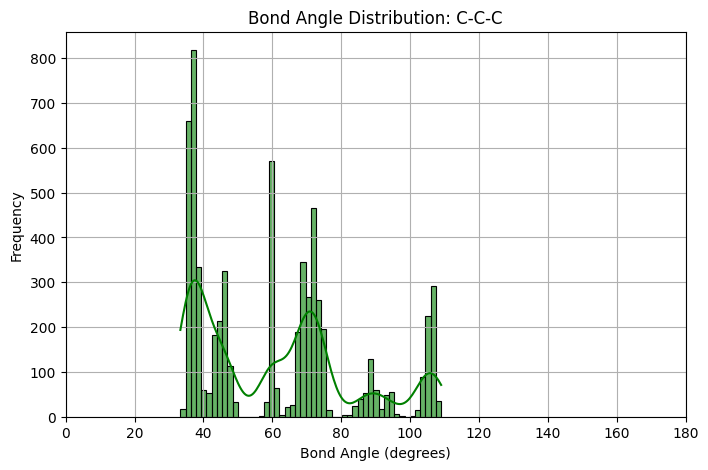

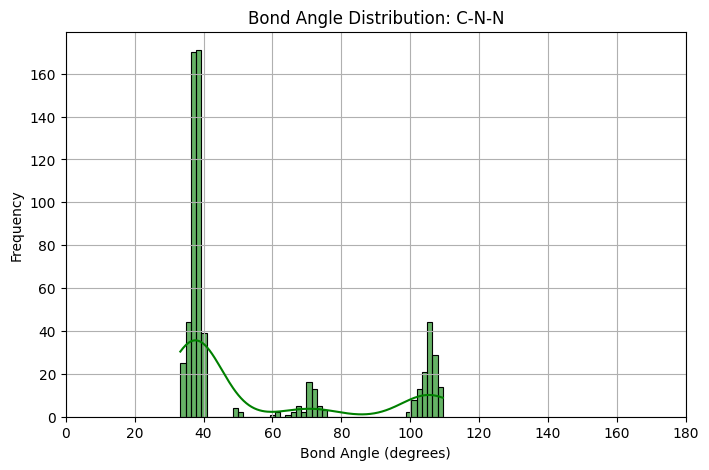

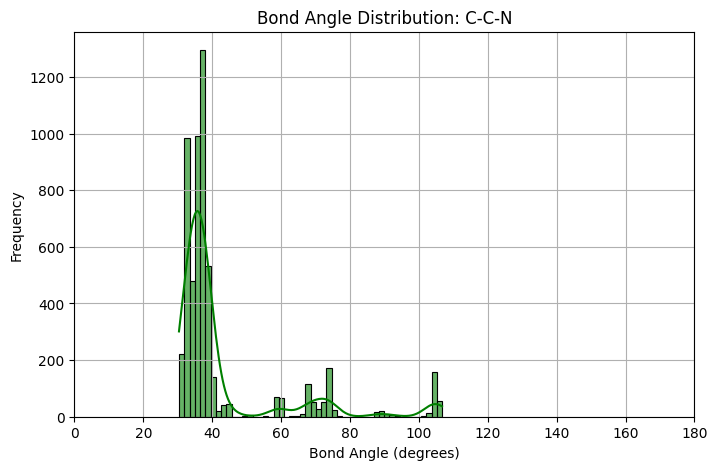

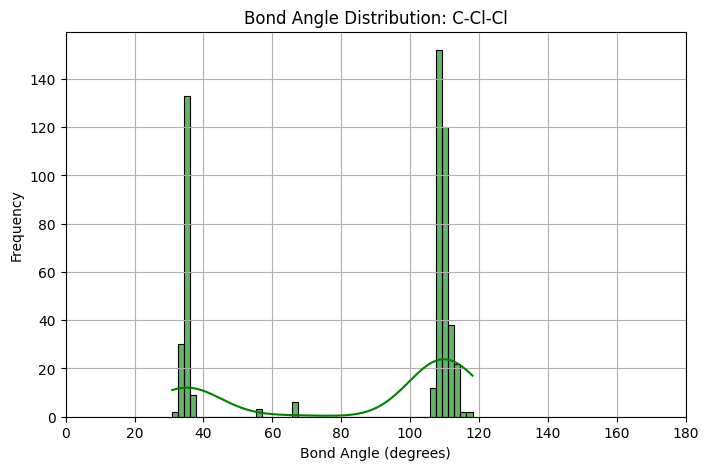

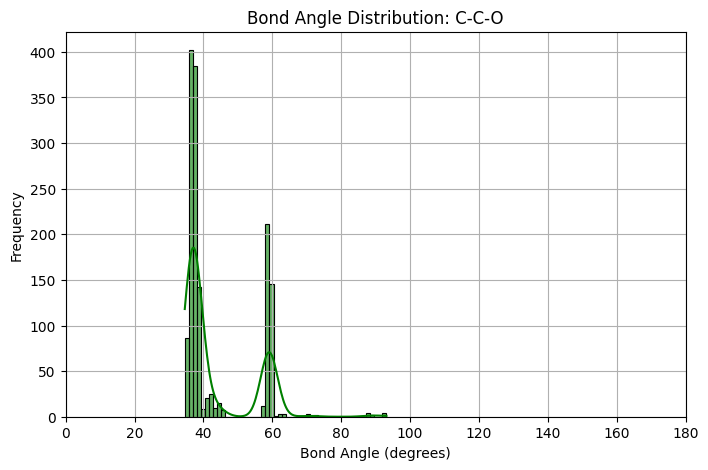

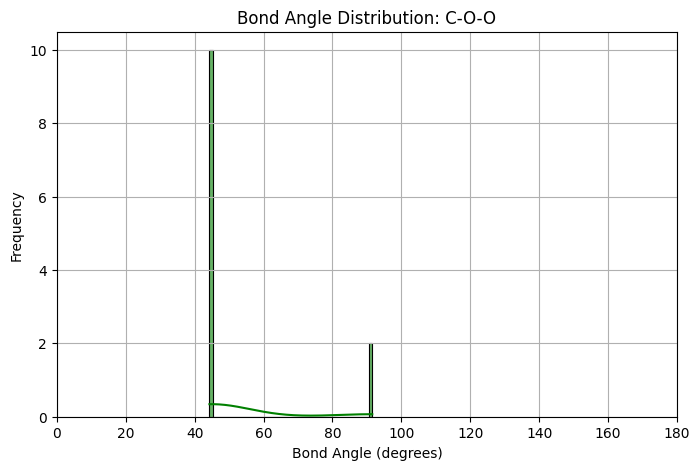

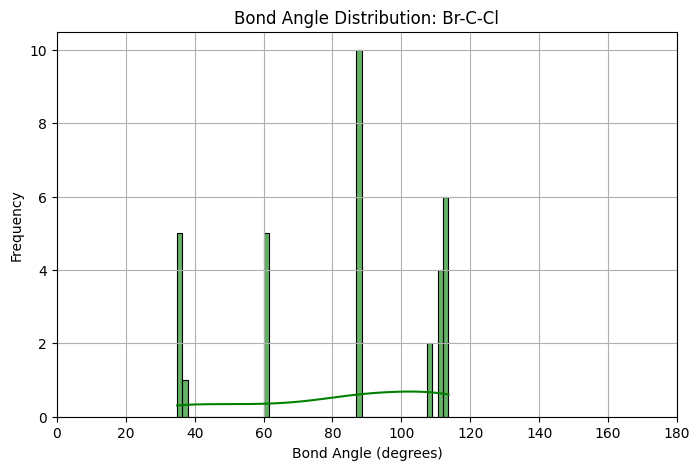

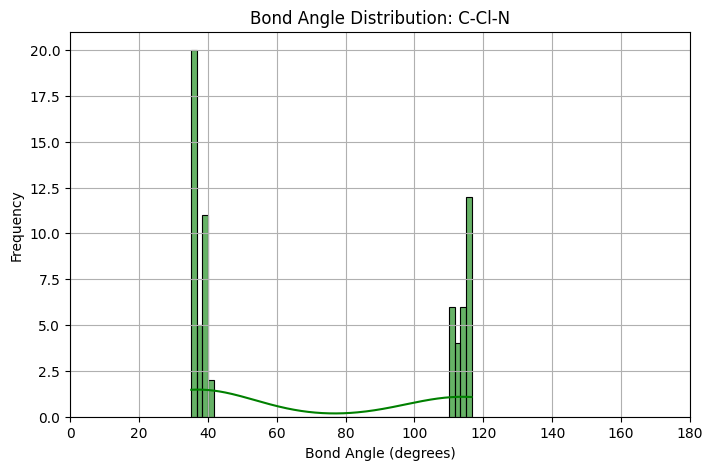

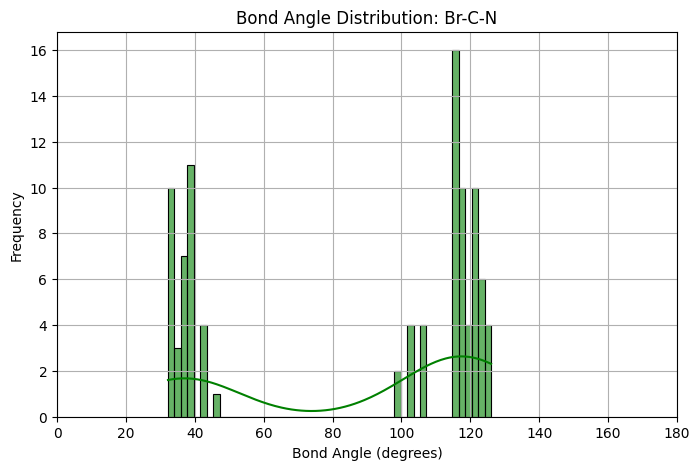

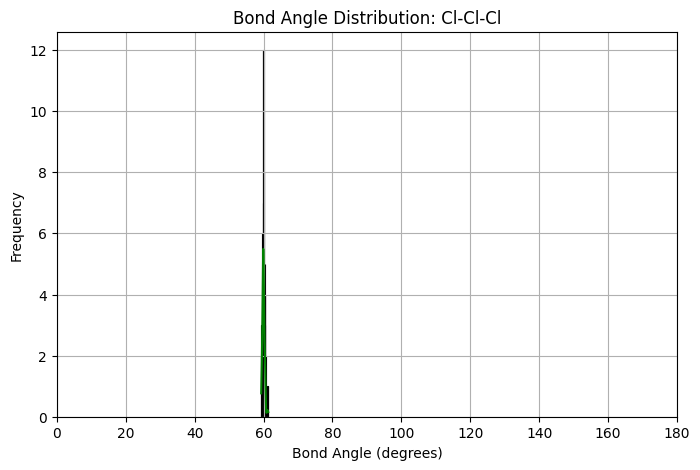

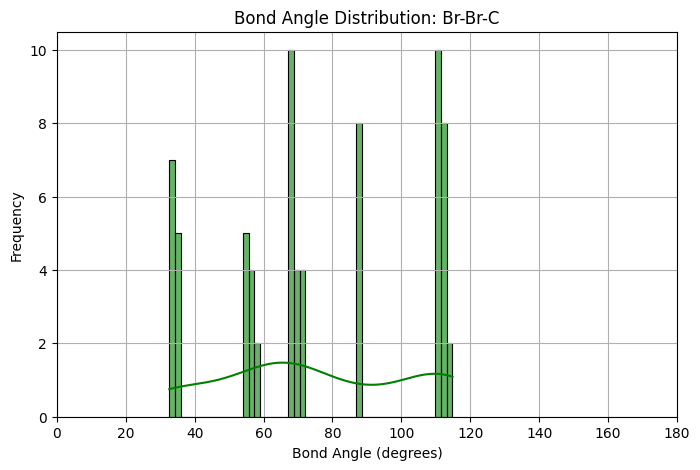

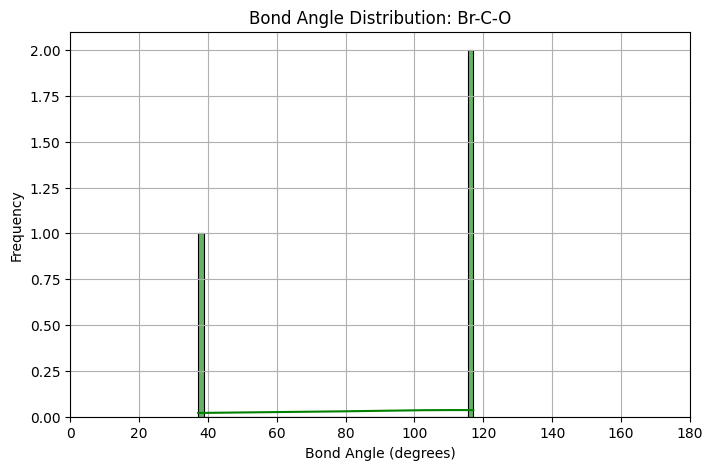

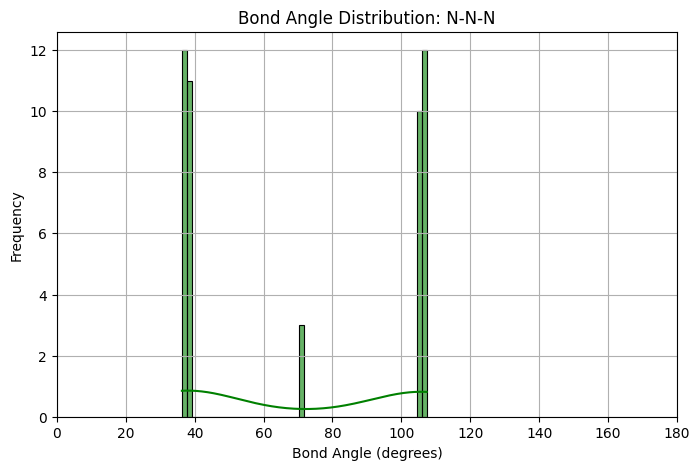

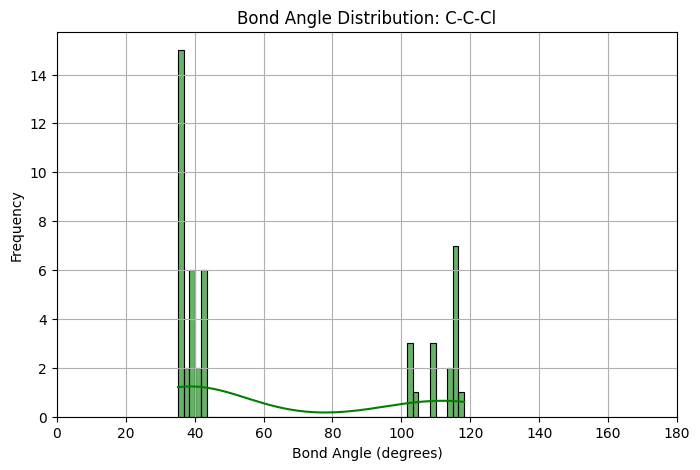

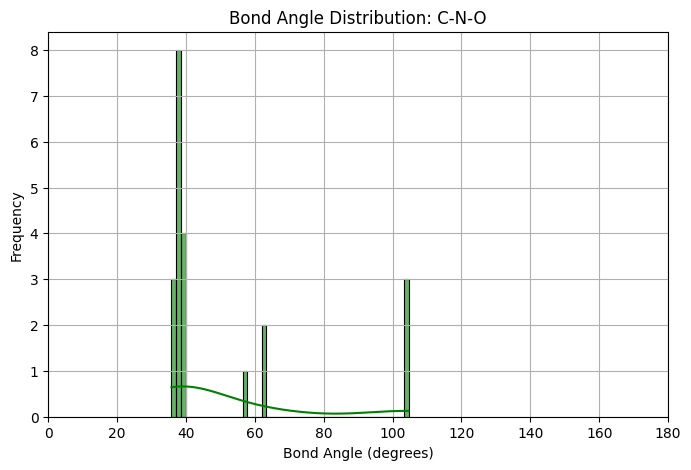

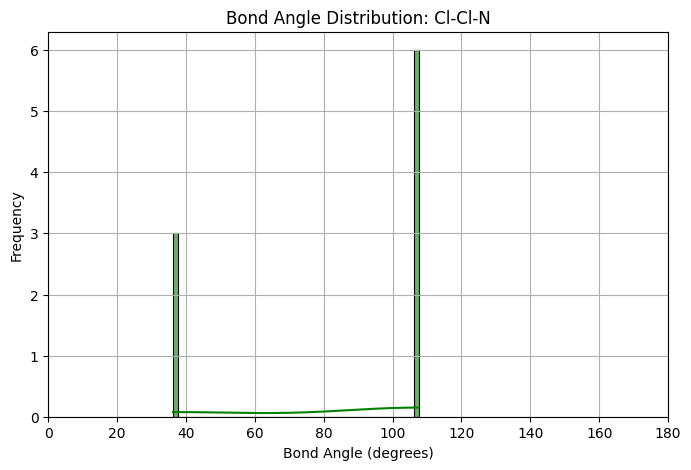

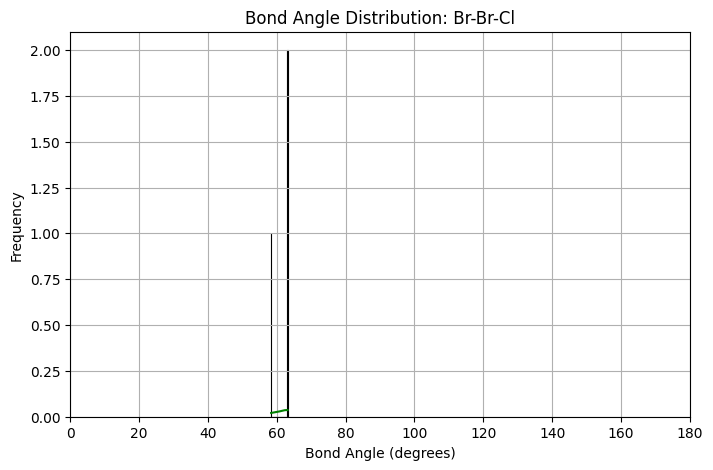

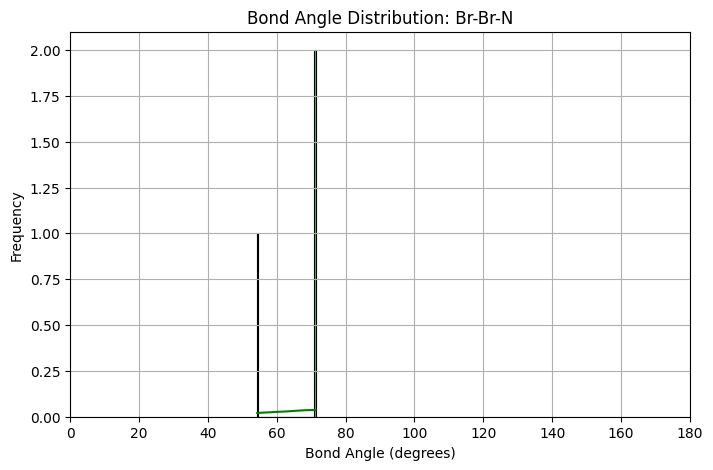

In [100]:
plot_bond_angle_distributions(bond_angle_dict)